## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Then I calculate matrix which will be used to calibrate camera, undistort image and Transform Perspective

In [2]:
img = plt.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2][::-1], None, None)

## And then I define all function I will used in pipeline

### step1.undistortion

In [3]:
#function1:undistort a image
def CalUndistort(img, mtx, dist):
    # Use cv2.calibrateCamera() and cv2.undistort()
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

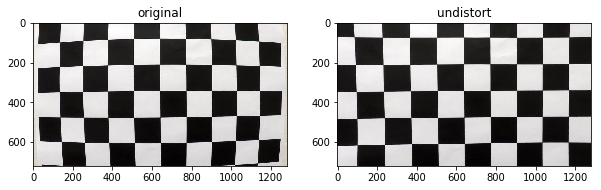

In [4]:
#test CalUndistort function
%matplotlib inline
img_test_Undistort = plt.imread('./camera_cal/calibration1.jpg')
img_result_Undistort = CalUndistort(img_test_Undistort,mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 9))
ax1.set_title('original')
ax1.imshow(img_test_Undistort, cmap='gray')
ax2.set_title('undistort')
ax2.imshow(img_result_Undistort, cmap='gray')

### step2. Color and Gradient Threshold

In [5]:
#calculate absolute sobel value,possibly used in pipeline function : ColorGradientThreshold()
def SobelAbs(image_channel,axis,sobel_kernel=3):
    sobel = None 
    if axis == 'x':
        sobel = cv2.Sobel(image_channel, cv2.CV_64F, 1,0,ksize=sobel_kernel) 
    elif axis == 'y':
        sobel = cv2.Sobel(image_channel, cv2.CV_64F, 0,1,ksize=sobel_kernel) 
    abs_sobel = np.absolute(sobel) 
    return abs_sobel

#calculate direction of the gradient, also possibly used in pipeline function : ColorGradientThreshold()
def DirThreshold(image_channel, sobel_kernel=3, thresh=(0, np.pi/2)):
    abs_sobelx = SobelAbs(image_channel,axis='x',sobel_kernel=sobel_kernel)
    abs_sobely = SobelAbs(image_channel,axis='y',sobel_kernel=sobel_kernel)
    direction = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(image_channel)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary_output
    
#calculate the gradient magnitude, also possibly used in pipeline function : ColorGradientThreshold()
def MagThresh(image_channel, sobel_kernel=3, mag_thresh=(0, 255)):
    abs_sobelx = SobelAbs(image_channel,axis='x',sobel_kernel=sobel_kernel)
    abs_sobely = SobelAbs(image_channel,axis='y',sobel_kernel=sobel_kernel)
    gradmag = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output


def ColorGradientThreshold(undistorted):
    hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS)
    
    h_channel = hls[:,:,0]
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    gray = cv2.cvtColor(undistorted, cv2.COLOR_BGR2GRAY) 
    abs_sobelx = SobelAbs(gray , axis='x',sobel_kernel=3) 
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    abs_sobely = SobelAbs(gray , axis='y',sobel_kernel=3)
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))

    s_thresh_min = 70
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    magOutput = MagThresh(l_channel, sobel_kernel=3, mag_thresh=(20,100))
    combined_binary = np.zeros_like(magOutput)
    combined_binary[(s_binary == 1) | (magOutput == 1)] = 1
    return combined_binary



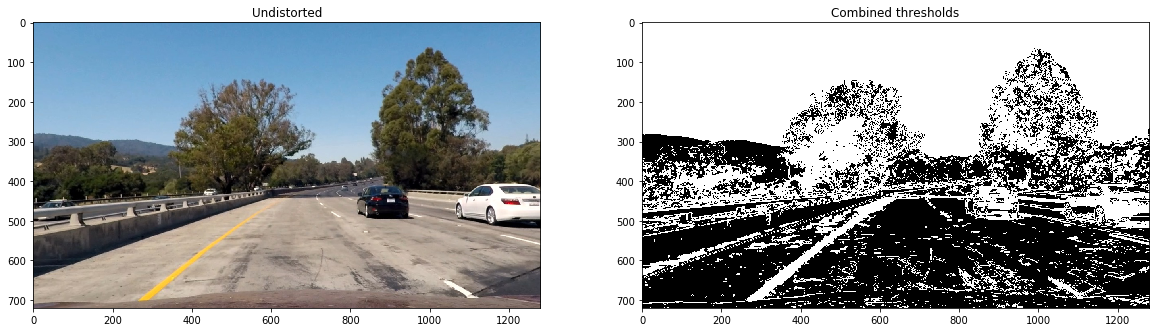

In [6]:
#test ColorGradientThreshold function
img_test_threshold = plt.imread('./test_images/test1.jpg')
img_result_undistort = CalUndistort(img_test_threshold,mtx, dist)
combined_binary = ColorGradientThreshold(img_result_undistort)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted')
ax1.imshow(img_result_undistort)
ax2.set_title('Combined thresholds')
ax2.imshow(combined_binary, cmap='gray')

### step3.Transform Perspective

In [7]:
#apply transform perspective
def TransformPerspective(img):
    image_size = img.shape[0:2]
    image_size_reverse = image_size[::-1]
    offset = 300
    img_size = image_size_reverse
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img , M, image_size_reverse , flags=cv2.INTER_LINEAR)
    return warped,M

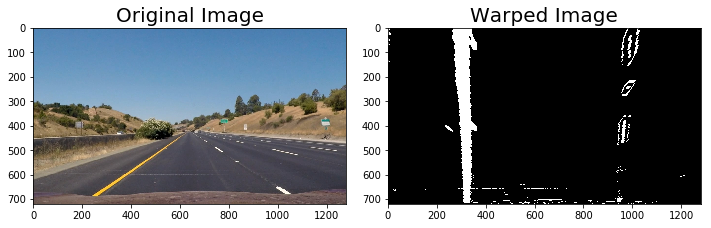

In [8]:
#test transform perspective
img_test_transform = plt.imread('./test_images/straight_lines1.jpg')
img_result_undistort = CalUndistort(img_test_transform,mtx, dist)
combined_binary = ColorGradientThreshold(img_result_undistort)
warped,M = TransformPerspective(combined_binary)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 9))
f.tight_layout()
ax1.imshow(img_test_transform)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(warped,cmap='gray')
ax2.set_title('Warped Image', fontsize=20)

### step4. Fit Polynomial

In [9]:
#fit polynomial for lane curve after transform perspective
def FitPolynomial(binary_warped):
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()

    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit,right_fit,out_img

#after first frame, we can use FitPolynomialEasy() function to fit polynomial
def FitPolynomialEasy(binary_warped,left_fit,right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit,right_fit

#calculate curverad of polynomial result
def CalCurverad(ploty,left_fitx,right_fitx):
    # Define conversions in x and y from pixels space to meters
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    offset_pixel = (left_fitx[-1] + right_fitx[-1])/2 - 640
    offset_cr = offset_pixel*xm_per_pix
    # Now our radius of curvature is in meters
    # Example values: 632.1 m    626.2 m
    return left_curverad, right_curverad,offset_cr

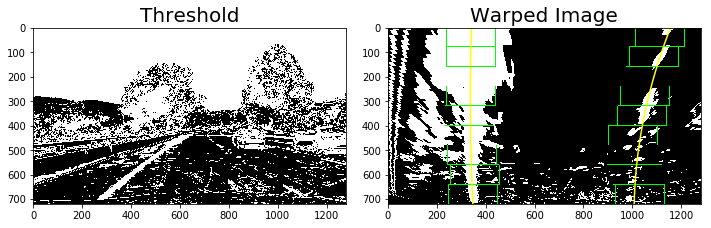

In [10]:
#test FitPolynomial(binary_warped) function
img_test_fit = plt.imread('./test_images/test1.jpg')
img_result_undistort = CalUndistort(img_test_fit,mtx, dist)
combined_binary = ColorGradientThreshold(img_result_undistort)
binary_warped,M = TransformPerspective(combined_binary)
left_test_fit, right_test_fit, out_img  = FitPolynomial(binary_warped)

ploty_test_fit = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_test_fit[0]*ploty_test_fit**2 + left_test_fit[1]*ploty_test_fit + left_test_fit[2]
right_fitx = right_test_fit[0]*ploty_test_fit**2 + right_test_fit[1]*ploty_test_fit + right_test_fit[2]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 9))
f.tight_layout()
ax1.imshow(combined_binary,cmap='gray')
ax1.set_title('Threshold', fontsize=20)
ax2.imshow(out_img,cmap='gray')
ax2.set_title('Warped Image', fontsize=20)
ax2.plot(left_fitx, ploty_test_fit, color='yellow')
ax2.plot(right_fitx, ploty_test_fit, color='yellow')

### step5.draw detected area in image

In [11]:
def DrawInImg(undistorted,warped,left_fitx,right_fitx,ploty,M):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    Minv = np.linalg.inv(M)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    left_curverad, right_curverad,offset = CalCurverad(ploty,left_fitx,right_fitx)
    radius = (left_curverad+right_curverad)/2
    cv2.putText(result, "left curverad: %.3f m" %(left_curverad), (30,30), cv2.FONT_HERSHEY_SIMPLEX, 1, 2, thickness=2)
    cv2.putText(result, "right curverad: %.3f m" % ( right_curverad), (30,90), cv2.FONT_HERSHEY_SIMPLEX, 1, 2, thickness=2) 
    cv2.putText(result, "radius: %.3f m" % ( radius), (30,150), cv2.FONT_HERSHEY_SIMPLEX, 1, 2,thickness=2) 
    if offset > 0 : 
        cv2.putText(result, "right offst: %.3f m" % ( offset), (30,210), cv2.FONT_HERSHEY_SIMPLEX, 1, 2,thickness=2) 
    elif offset == 0 : 
        cv2.putText(result, "no offset" , (30,210), cv2.FONT_HERSHEY_SIMPLEX, 1, 2,thickness=2) 
    else:
        cv2.putText(result, "left offst: %.3f m" % ( -offset), (30,210), cv2.FONT_HERSHEY_SIMPLEX, 1, 2,thickness=2) 
    return result 

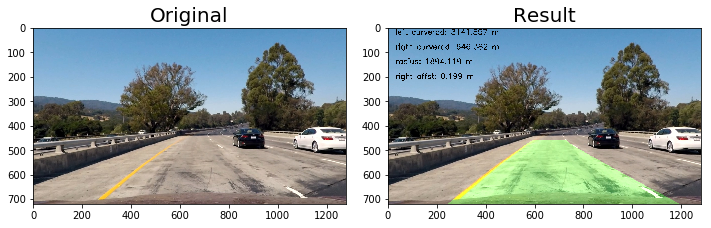

In [12]:
#test DrawInImg function
img_test_fit = plt.imread('./test_images/test1.jpg')
img_result_undistort = CalUndistort(img_test_fit,mtx, dist)
combined_binary = ColorGradientThreshold(img_result_undistort)
binary_warped,M = TransformPerspective(combined_binary)
left_test_fit, right_test_fit, out_img  = FitPolynomial(binary_warped)

ploty_test_fit = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_test_fit[0]*ploty_test_fit**2 + left_test_fit[1]*ploty_test_fit + left_test_fit[2]
right_fitx = right_test_fit[0]*ploty_test_fit**2 + right_test_fit[1]*ploty_test_fit + right_test_fit[2]

result_draw = DrawInImg(img_result_undistort,binary_warped,left_fitx,right_fitx,ploty_test_fit,M)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 9))
f.tight_layout()
ax1.imshow(img_result_undistort)
ax1.set_title('Original', fontsize=20)
ax2.imshow(result_draw)
ax2.set_title('Result', fontsize=20)


## combine all function in order to process video

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
i = 1
def process_image(image):
    undistorted = CalUndistort(image, mtx, dist)
    combined_binary = ColorGradientThreshold(undistorted)
    warped,M = TransformPerspective(combined_binary)
    binary_warped = warped
    result = None
    global i
    global left_fit 
    global right_fit 
    global ploty
    if i == 1: 
        left_fit,right_fit,out_img  = FitPolynomial(binary_warped)
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        result = DrawInImg(undistorted,binary_warped,left_fitx,right_fitx,ploty,M)
        i = i+1
    else:
        left_fit,right_fit = FitPolynomialEasy(binary_warped,left_fit,right_fit)
        ploty = np.linspace(0, binary_warped .shape[0]-1, binary_warped .shape[0] )
        left_fitx_later = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx_later = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        result = DrawInImg(undistorted,binary_warped,left_fitx_later,right_fitx_later,ploty,M)

    return result

In [15]:
white_output = 'test_videos_output_final.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output_final.mp4
[MoviePy] Writing video test_videos_output_final.mp4


100%|█████████▉| 1260/1261 [04:50<00:00,  4.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output_final.mp4 

CPU times: user 8min 52s, sys: 4min 24s, total: 13min 16s
Wall time: 4min 52s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [17]:
white_output = 'challenge_videos_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video challenge_videos_output.mp4
[MoviePy] Writing video challenge_videos_output.mp4


100%|██████████| 485/485 [01:57<00:00,  4.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_videos_output.mp4 

CPU times: user 3min 34s, sys: 1min 42s, total: 5min 17s
Wall time: 1min 58s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))